In [ ]:
# https://qiskit.org/documentation/tutorials/circuits/1_getting_started_with_qiskit.html
# https://qiskit.org/documentation/machine-learning/tutorials/03_quantum_kernel.html
# https://github.com/marcinjastrzebski8/QuantumKernelEstimation  (useful as a small guide)
# https://xavierbourretsicotte.github.io/SVM_implementation.html
# https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf  ===> how to use cvxopt

# TODO : see if one can improve accuracy
# TODO : graphics to draw the separation hyperplane and see if it has the margins promised in the paper
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, BasicAer, transpile, Aer, IBMQ
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.kernels import QuantumKernel
from cvxopt import matrix, solvers
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame
import os

seed = 12345
algorithm_globals.random_seed = seed
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['font.size'] = 12

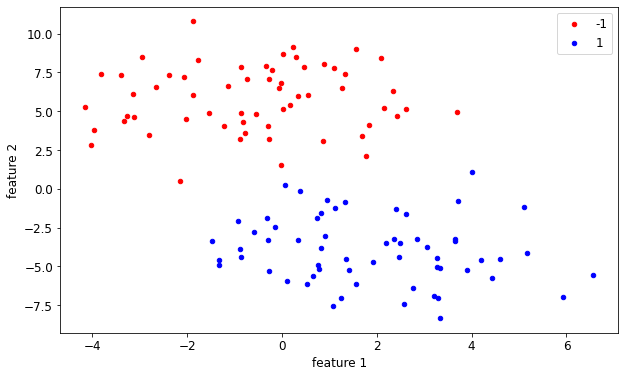

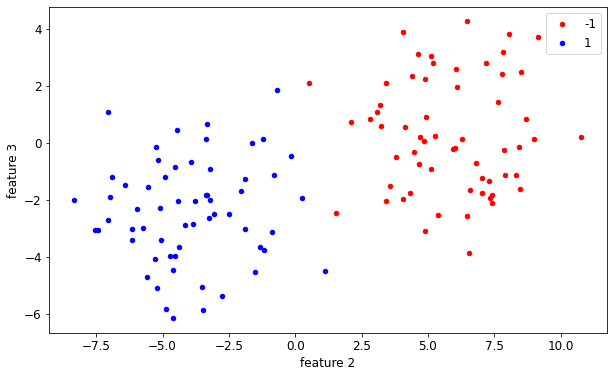

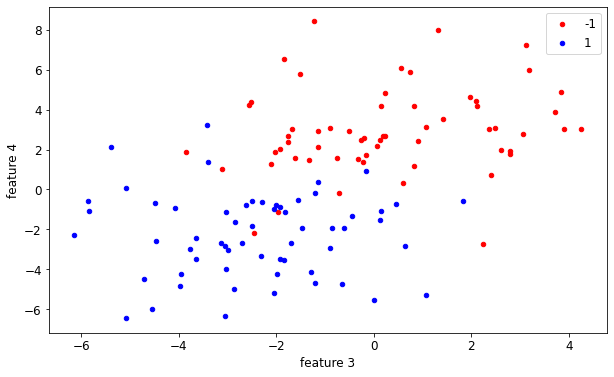

In [4]:
# Creating a dataset
# The smaller the cluster_std, the more appart and easier to distinguish they are
num_samples_train = 100
num_samples_test = 20
num_features = 4

num_samples = num_samples_train + num_samples_test
all_features, all_labels_init = make_blobs(n_samples=num_samples, centers=2, cluster_std=2, n_features=num_features)

features_train = all_features[:num_samples_train]
features_test = all_features[num_samples_train:]

labels = all_labels_init
labels = np.where(all_labels_init == 0, -1, all_labels_init)

labels_train = labels[:num_samples_train]
labels_test = labels[num_samples_train:]

# Displaying the dataset
features_dict = {}
for i in range(len(all_features[0])):
    col_name = "feature " + str(i+1)
    features_dict [col_name] = all_features[:,i]
    
features_dict["label"] = labels
df = DataFrame(features_dict, labels)
df.to_csv('./data_paulifm.csv')  

colors = {-1:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')

for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='feature 1', y='feature 2', label=key, color=colors[key])
plt.savefig('pauli_fm_f1_f2.png')
plt.show()

features_dict["label"] = labels
df = DataFrame(features_dict, labels)
colors = {-1:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')

for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='feature 2', y='feature 3', label=key, color=colors[key])
plt.savefig('pauli_fm_f2_f3.png')
plt.show()

features_dict["label"] = labels
df = DataFrame(features_dict, labels)
colors = {-1:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')

for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='feature 3', y='feature 4', label=key, color=colors[key])
plt.savefig('pauli_fm_f3_f4.png')
plt.show()

['Y', 'XX']
     pcost       dcost       gap    pres   dres
 0: -4.9954e-02 -1.4976e-01  1e-01  0e+00  1e+00
 1: -4.9954e-02 -5.0953e-02  1e-03  2e-18  1e-02
 2: -4.9954e-02 -4.9964e-02  1e-05  2e-18  1e-04
 3: -4.9954e-02 -4.9954e-02  1e-07  2e-18  1e-06
 4: -4.9954e-02 -4.9954e-02  1e-09  3e-18  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.9542e-01 -1.4768e+00  1e+00  0e+00  1e+00
 1: -4.9546e-01 -5.0540e-01  1e-02  2e-17  1e-02
 2: -4.9547e-01 -4.9557e-01  1e-04  2e-17  1e-04
 3: -4.9547e-01 -4.9547e-01  1e-06  2e-17  1e-06
 4: -4.9547e-01 -4.9547e-01  1e-08  2e-17  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.5723e+00 -1.3118e+01  9e+00  0e+00  1e+00
 1: -4.6027e+00 -4.7183e+00  1e-01  2e-16  4e-02
 2: -4.6055e+00 -4.6067e+00  1e-03  2e-16  4e-04
 3: -4.6055e+00 -4.6055e+00  1e-05  2e-16  4e-06
 4: -4.6055e+00 -4.6055e+00  1e-07  2e-16  4e-08
Optimal solution found.
     pcost       dcost       gap    p

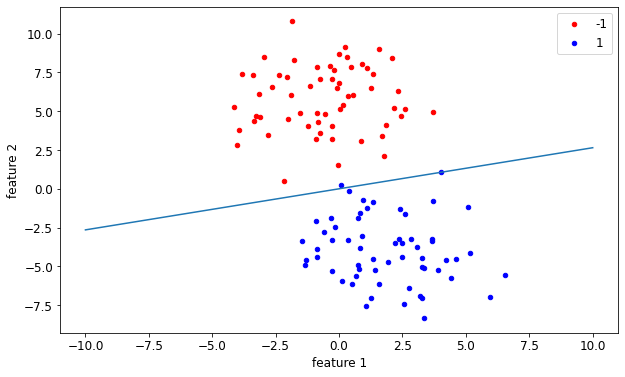

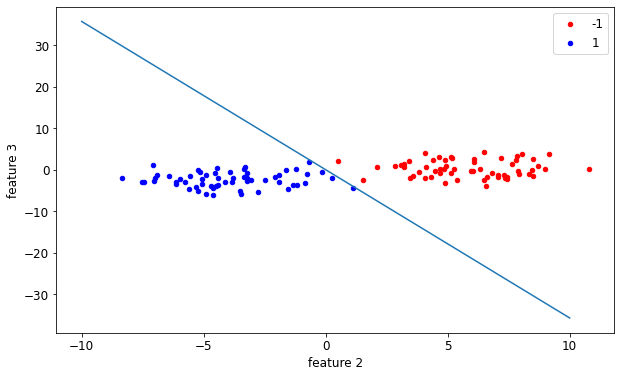

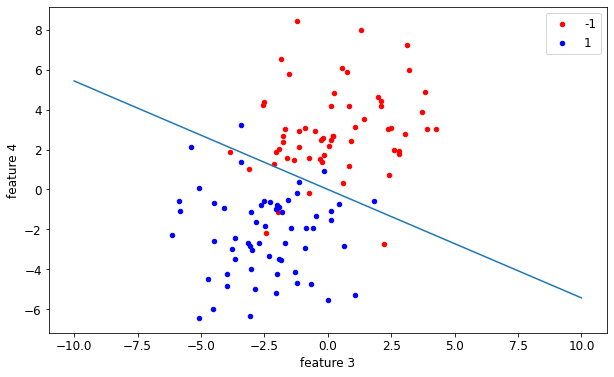

['Y', 'XY']
     pcost       dcost       gap    pres   dres
 0: -4.9951e-02 -1.4975e-01  1e-01  0e+00  1e+00
 1: -4.9951e-02 -5.0950e-02  1e-03  2e-18  1e-02
 2: -4.9951e-02 -4.9961e-02  1e-05  2e-18  1e-04
 3: -4.9951e-02 -4.9952e-02  1e-07  2e-18  1e-06
 4: -4.9951e-02 -4.9951e-02  1e-09  2e-18  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.9517e-01 -1.4762e+00  1e+00  0e+00  1e+00
 1: -4.9522e-01 -5.0517e-01  1e-02  2e-17  1e-02
 2: -4.9522e-01 -4.9532e-01  1e-04  2e-17  1e-04
 3: -4.9522e-01 -4.9522e-01  1e-06  2e-17  1e-06
 4: -4.9522e-01 -4.9522e-01  1e-08  2e-17  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.5525e+00 -1.3099e+01  9e+00  0e+00  1e+00
 1: -4.5826e+00 -4.7053e+00  1e-01  2e-16  4e-02
 2: -4.5853e+00 -4.5866e+00  1e-03  2e-16  4e-04
 3: -4.5853e+00 -4.5854e+00  1e-05  2e-16  4e-06
 4: -4.5853e+00 -4.5853e+00  1e-07  2e-16  4e-08
Optimal solution found.
     pcost       dcost       gap    p

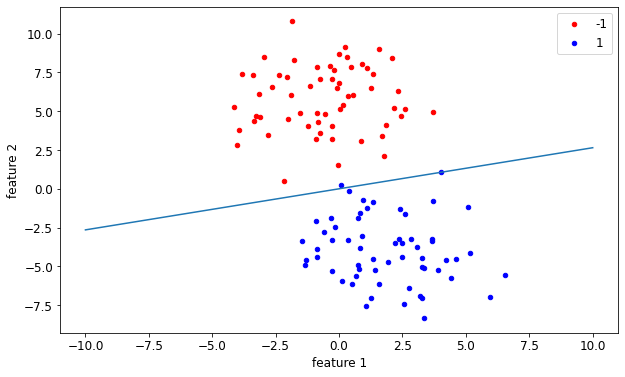

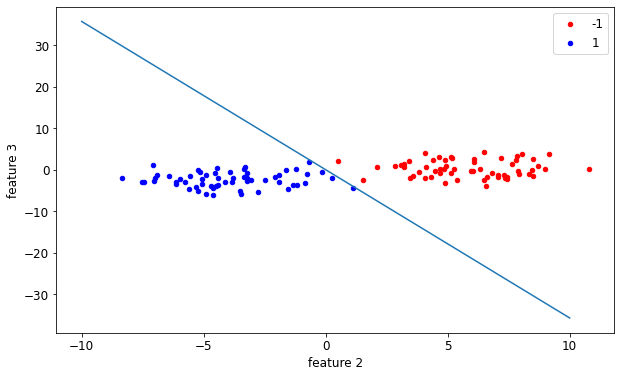

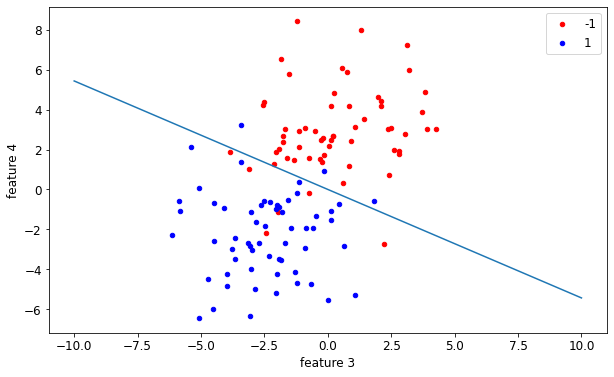

['Y', 'XZ']
     pcost       dcost       gap    pres   dres
 0: -4.9955e-02 -1.4977e-01  1e-01  0e+00  1e+00
 1: -4.9955e-02 -5.0954e-02  1e-03  2e-18  1e-02
 2: -4.9955e-02 -4.9965e-02  1e-05  2e-18  1e-04
 3: -4.9955e-02 -4.9955e-02  1e-07  2e-18  1e-06
 4: -4.9955e-02 -4.9955e-02  1e-09  2e-18  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.9555e-01 -1.4773e+00  1e+00  0e+00  1e+00
 1: -4.9559e-01 -5.0554e-01  1e-02  2e-17  1e-02
 2: -4.9559e-01 -4.9569e-01  1e-04  2e-17  1e-04
 3: -4.9559e-01 -4.9560e-01  1e-06  2e-17  1e-06
 4: -4.9559e-01 -4.9559e-01  1e-08  2e-17  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.5801e+00 -1.3171e+01  9e+00  0e+00  1e+00
 1: -4.6105e+00 -4.7308e+00  1e-01  2e-16  4e-02
 2: -4.6134e+00 -4.6146e+00  1e-03  2e-16  4e-04
 3: -4.6134e+00 -4.6134e+00  1e-05  2e-16  4e-06
 4: -4.6134e+00 -4.6134e+00  1e-07  2e-16  4e-08
Optimal solution found.
     pcost       dcost       gap    p

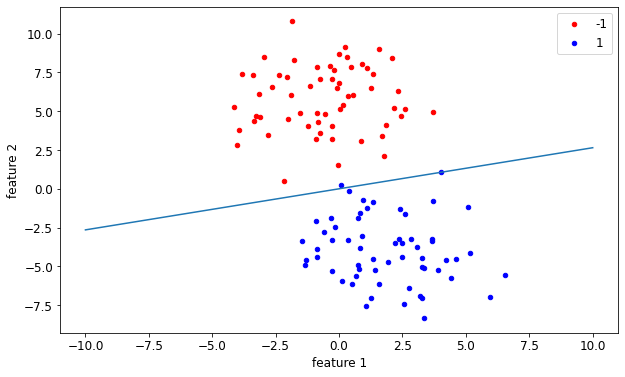

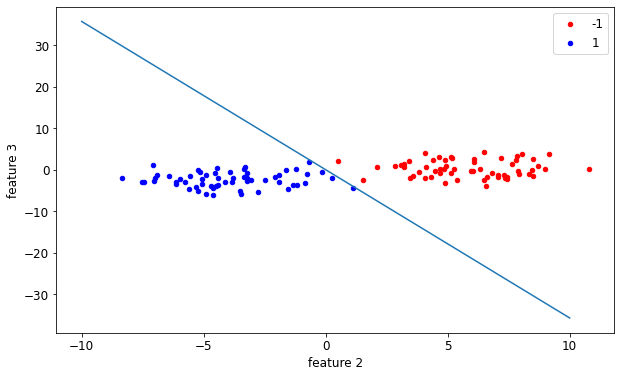

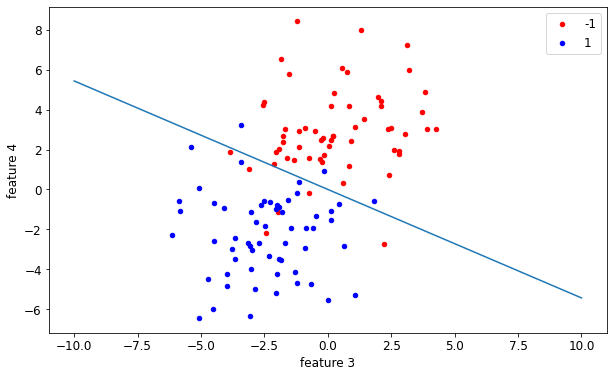

['Y', 'YX']
     pcost       dcost       gap    pres   dres
 0: -4.9952e-02 -1.4976e-01  1e-01  0e+00  1e+00
 1: -4.9952e-02 -5.0951e-02  1e-03  2e-18  1e-02
 2: -4.9952e-02 -4.9962e-02  1e-05  2e-18  1e-04
 3: -4.9952e-02 -4.9952e-02  1e-07  2e-18  1e-06
 4: -4.9952e-02 -4.9952e-02  1e-09  2e-18  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.9523e-01 -1.4763e+00  1e+00  0e+00  1e+00
 1: -4.9527e-01 -5.0522e-01  1e-02  2e-17  1e-02
 2: -4.9528e-01 -4.9538e-01  1e-04  2e-17  1e-04
 3: -4.9528e-01 -4.9528e-01  1e-06  2e-17  1e-06
 4: -4.9528e-01 -4.9528e-01  1e-08  2e-17  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.5622e+00 -1.3128e+01  9e+00  0e+00  1e+00
 1: -4.5924e+00 -4.7165e+00  1e-01  2e-16  4e-02
 2: -4.5953e+00 -4.5966e+00  1e-03  2e-16  4e-04
 3: -4.5953e+00 -4.5953e+00  1e-05  2e-16  4e-06
 4: -4.5953e+00 -4.5953e+00  1e-07  2e-16  4e-08
Optimal solution found.
     pcost       dcost       gap    p

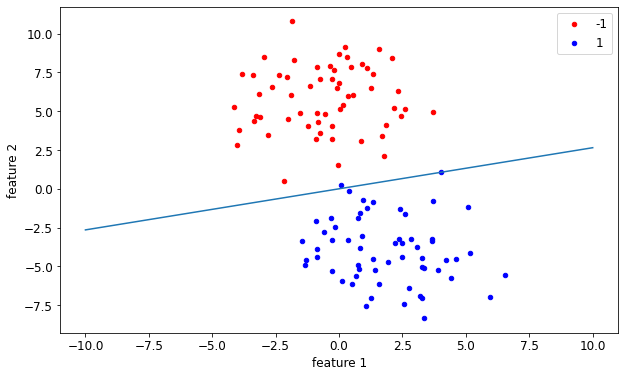

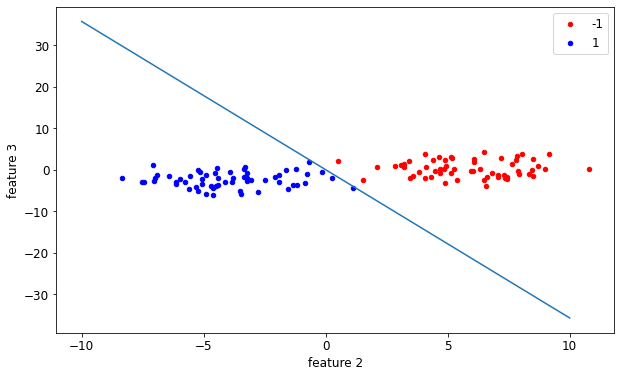

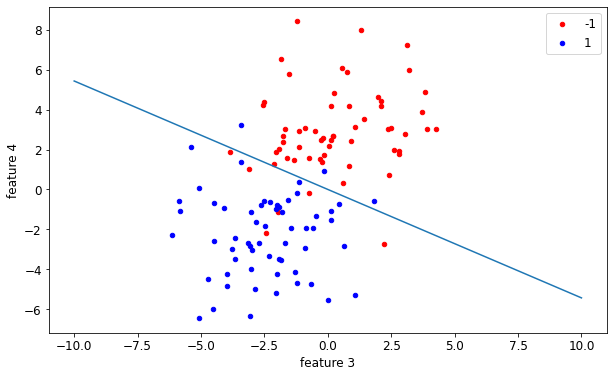

['Y', 'YY']
     pcost       dcost       gap    pres   dres
 0: -4.9952e-02 -1.4976e-01  1e-01  0e+00  1e+00
 1: -4.9952e-02 -5.0951e-02  1e-03  2e-18  1e-02
 2: -4.9952e-02 -4.9962e-02  1e-05  2e-18  1e-04
 3: -4.9952e-02 -4.9952e-02  1e-07  2e-18  1e-06
 4: -4.9952e-02 -4.9952e-02  1e-09  2e-18  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.9520e-01 -1.4761e+00  1e+00  0e+00  1e+00
 1: -4.9524e-01 -5.0516e-01  1e-02  2e-17  1e-02
 2: -4.9525e-01 -4.9534e-01  1e-04  2e-17  1e-04
 3: -4.9525e-01 -4.9525e-01  1e-06  2e-17  1e-06
 4: -4.9525e-01 -4.9525e-01  1e-08  2e-17  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.5475e+00 -1.3016e+01  8e+00  0e+00  1e+00
 1: -4.5774e+00 -4.6888e+00  1e-01  2e-16  4e-02
 2: -4.5801e+00 -4.5812e+00  1e-03  2e-16  4e-04
 3: -4.5801e+00 -4.5801e+00  1e-05  2e-16  4e-06
 4: -4.5801e+00 -4.5801e+00  1e-07  2e-16  4e-08
Optimal solution found.
     pcost       dcost       gap    p

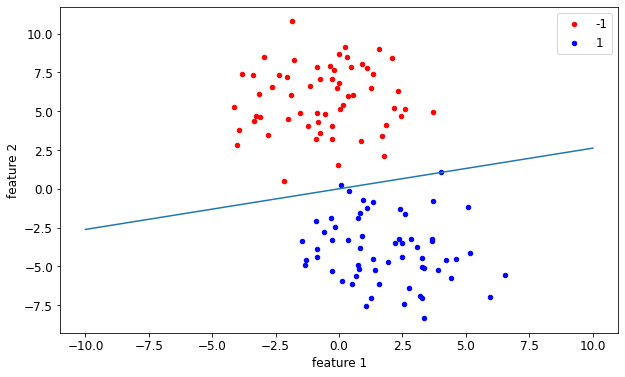

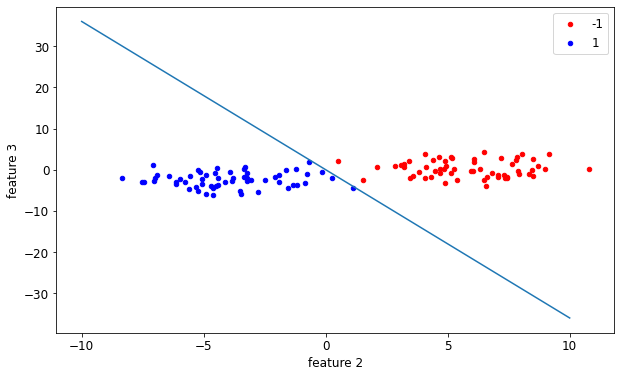

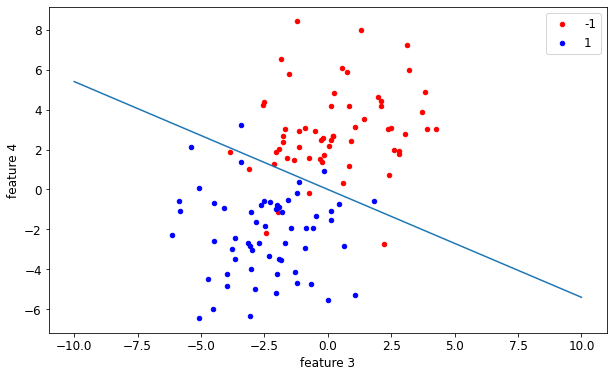

['Y', 'YZ']
     pcost       dcost       gap    pres   dres
 0: -4.9940e-02 -1.4972e-01  1e-01  0e+00  1e+00
 1: -4.9940e-02 -5.0938e-02  1e-03  2e-18  1e-02
 2: -4.9940e-02 -4.9950e-02  1e-05  2e-18  1e-04
 3: -4.9940e-02 -4.9940e-02  1e-07  2e-18  1e-06
 4: -4.9940e-02 -4.9940e-02  1e-09  2e-18  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.9407e-01 -1.4729e+00  1e+00  0e+00  1e+00
 1: -4.9411e-01 -5.0404e-01  1e-02  2e-17  1e-02
 2: -4.9411e-01 -4.9421e-01  1e-04  2e-17  1e-04
 3: -4.9411e-01 -4.9411e-01  1e-06  2e-17  1e-06
 4: -4.9411e-01 -4.9411e-01  1e-08  2e-17  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.4782e+00 -1.2906e+01  8e+00  0e+00  1e+00
 1: -4.5071e+00 -4.6314e+00  1e-01  2e-16  4e-02
 2: -4.5098e+00 -4.5111e+00  1e-03  2e-16  4e-04
 3: -4.5098e+00 -4.5098e+00  1e-05  2e-16  4e-06
 4: -4.5098e+00 -4.5098e+00  1e-07  2e-16  4e-08
Optimal solution found.
     pcost       dcost       gap    p

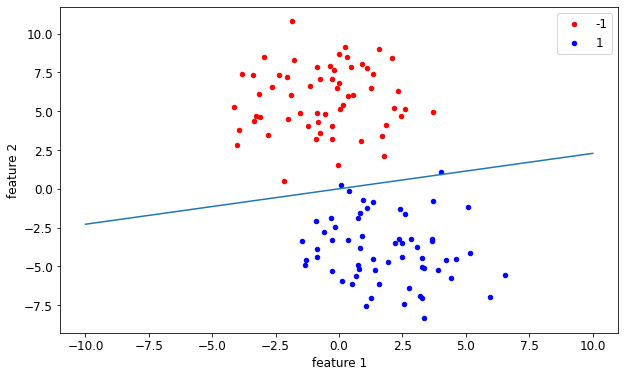

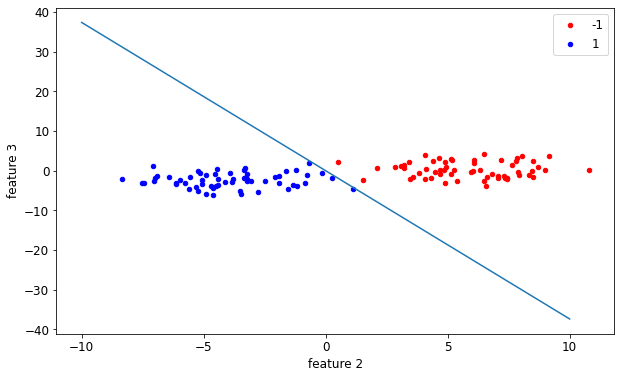

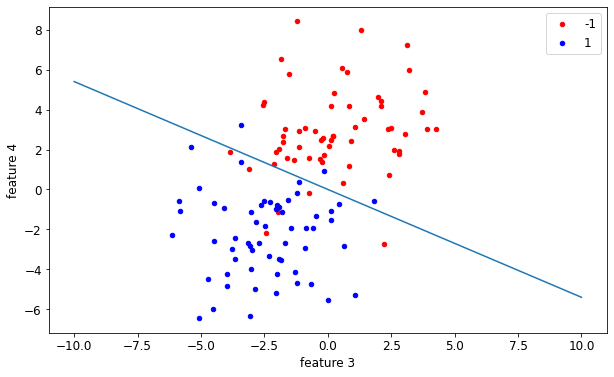

['Y', 'ZX']


In [ ]:
### Custom Feature Map

# for now, we have as many qubits as features
num_qubits = num_features
      
# creating a list of parameters
x = ParameterVector('x', length=num_qubits)  
custom_circ = QuantumCircuit(num_qubits)

# creating the feature map and extracting the kernel matrix
backend = QuantumInstance(Aer.get_backend("qasm_simulator"), shots=1024, seed_simulator=seed, seed_transpiler=seed)

for gate1 in ['Y', 'Z']:
    for gate2 in ['X', 'Y', 'Z']:
        for gate3 in ['X', 'Y', 'Z']:

            paulis = [gate1, gate2+gate3]
            print(paulis)

            paulis_string = "_".join(paulis)
            foldername = "./all_results_for_" + paulis_string + "/"
            os.mkdir(foldername)

            fm = PauliFeatureMap(num_qubits, reps=1, paulis=paulis)
            qk = QuantumKernel(feature_map=fm, quantum_instance=backend)
            K = qk.evaluate(features_train)

            numerical_results_filename = foldername + 'accuracy_results.txt'

            lambda_best_acc = -1
            best_acc = -1
            # Computing the alphas of the SVM algorithm
            for lambda_svm in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
                Q = np.zeros((num_samples_train, num_samples_train))
                for i in range(num_samples_train):
                    for j in range(num_samples_train):
                        Q[i][j] = labels[i] * labels[j] * K[i][j]
                Pm = np.eye(num_samples_train) / lambda_svm + Q

                P = matrix(Pm, tc='d')
                q = matrix(-np.ones(num_samples_train), tc='d')
                G = matrix(-np.eye(num_samples_train), tc='d')
                h = matrix(np.zeros(num_samples_train), tc='d')

                sol = solvers.qp(P,q,G,h)
                alpha = (np.array(sol['x']).T)[0]
                good = 0
                bad = 0
                for test_idx in range(num_samples_test):
                    new_sum = 0

                    for train_idx in range(num_samples_train):
                        pair = np.zeros((2, num_features))
                        pair[0] = features_train[train_idx]
                        pair[1] = features_test[test_idx]
                        current_K = qk.evaluate(pair)
                        new_sum = new_sum + alpha[train_idx] * labels_train[train_idx] * current_K[0][1] # x_i vs x (test)

                    if int(new_sum/abs(new_sum)) == int(labels_test[test_idx]):
                        good = good + 1
                    #    print("Good for " + str(test_idx))
                    else:
                        bad = bad + 1
                    #    print("Bad for " + str(test_idx))

                    if round(good / (good + bad), 4) * 100 > best_acc:
                        best_acc = round(good / (good + bad), 4) * 100
                        lambda_best_acc = lambda_svm

                with open(numerical_results_filename, 'a') as f:
                    print("Lambda is: ", lambda_svm, file=f)
                    print("Well classifed: ", good, file=f)
                    print("Bad classified: ", bad, file=f)
                    print("Accuracy: ", round(good / (good + bad), 4) * 100, file=f)
                    print('\n################################\n', file=f)


            # Plot for best lambda
            lambda_svm = lambda_best_acc # we plot for the best lambda
            Q = np.zeros((num_samples_train, num_samples_train))
            for i in range(num_samples_train):
                for j in range(num_samples_train):
                    Q[i][j] = labels[i] * labels[j] * K[i][j]
            Pm = np.eye(num_samples_train) / lambda_svm + Q

            P = matrix(Pm, tc='d')
            q = matrix(-np.ones(num_samples_train), tc='d')
            G = matrix(-np.eye(num_samples_train), tc='d')
            h = matrix(np.zeros(num_samples_train), tc='d')

            sol = solvers.qp(P,q,G,h)
            alpha = (np.array(sol['x']).T)[0]
            print(alpha[0:4])
            good = 0
            bad = 0

            w_0 = 0
            w_1 = 0
            w_2 = 0
            w_3 = 0

            for test_idx in range(num_samples_test):
                new_sum = 0

                for train_idx in range(num_samples_train):
                    pair = np.zeros((2, num_features))
                    pair[0] = features_train[train_idx]
                    pair[1] = features_test[test_idx]
                    current_K = qk.evaluate(pair)
                    new_sum = new_sum + alpha[train_idx] * labels_train[train_idx] * current_K[0][1] # x_i vs x (test)
                    w_0 = w_0 + alpha[train_idx] * labels_train[train_idx] * features_train[train_idx][0]
                    w_1 = w_1 + alpha[train_idx] * labels_train[train_idx] * features_train[train_idx][1]
                    w_2 = w_2 + alpha[train_idx] * labels_train[train_idx] * features_train[train_idx][2]
                    w_3 = w_3 + alpha[train_idx] * labels_train[train_idx] * features_train[train_idx][3]

            ##

            fig, ax = plt.subplots()

            for key, group in grouped:
                group.plot(ax=ax, kind='scatter', x='feature 1', y='feature 2', label=key, color=colors[key])

            x0_sample = np.linspace(-10.0, 10.0, num=1000)
            x1_sample = -w_0 * x0_sample / w_1
            ax.plot(x0_sample, x1_sample)

            plt.savefig(foldername + 'pauli_fm_hyperplane_f1_f2.png')
            plt.show()

            ##

            fig, ax = plt.subplots()

            for key, group in grouped:
                group.plot(ax=ax, kind='scatter', x='feature 2', y='feature 3', label=key, color=colors[key])

            x0_sample = np.linspace(-10.0, 10.0, num=1000)
            x1_sample = -w_1 * x0_sample / w_2
            ax.plot(x0_sample, x1_sample)

            plt.savefig(foldername + 'pauli_fm_hyperplane_f2_f3.png')
            plt.show()

            ##

            fig, ax = plt.subplots()

            for key, group in grouped:
                group.plot(ax=ax, kind='scatter', x='feature 3', y='feature 4', label=key, color=colors[key])

            x0_sample = np.linspace(-10.0, 10.0, num=1000)
            x1_sample = -w_2 * x0_sample / w_3
            ax.plot(x0_sample, x1_sample)

            plt.savefig(foldername + 'pauli_fm_hyperplane_f3_f4.png')
            plt.show()

In [ ]:
numerical_results_filename = foldername + 'accuracy_results.txt'

lambda_best_acc = -1
best_acc = -1
# Computing the alphas of the SVM algorithm
for lambda_svm in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    Q = np.zeros((num_samples_train, num_samples_train))
    for i in range(num_samples_train):
        for j in range(num_samples_train):
            Q[i][j] = labels[i] * labels[j] * K[i][j]
    Pm = np.eye(num_samples_train) / lambda_svm + Q

    P = matrix(Pm, tc='d')
    q = matrix(-np.ones(num_samples_train), tc='d')
    G = matrix(-np.eye(num_samples_train), tc='d')
    h = matrix(np.zeros(num_samples_train), tc='d')

    sol = solvers.qp(P,q,G,h)
    alpha = (np.array(sol['x']).T)[0]
    good = 0
    bad = 0
    for test_idx in range(num_samples_test):
        new_sum = 0

        for train_idx in range(num_samples_train):
            pair = np.zeros((2, num_features))
            pair[0] = features_train[train_idx]
            pair[1] = features_test[test_idx]
            current_K = qk.evaluate(pair)
            new_sum = new_sum + alpha[train_idx] * labels_train[train_idx] * current_K[0][1] # x_i vs x (test)

        if int(new_sum/abs(new_sum)) == int(labels_test[test_idx]):
            good = good + 1
        #    print("Good for " + str(test_idx))
        else:
            bad = bad + 1
        #    print("Bad for " + str(test_idx))
        
        if round(good / (good + bad), 4) * 100 > best_acc:
            best_acc = round(good / (good + bad), 4) * 100
            lambda_best_acc = lambda_svm
    
    with open(numerical_results_filename, 'a') as f:
        print("Lambda is: ", lambda_svm, file=f)
        print("Well classifed: ", good, file=f)
        print("Bad classified: ", bad, file=f)
        print("Accuracy: ", round(good / (good + bad), 4) * 100, file=f)
        print('\n################################\n', file=f)
        
        
    

In [ ]:
# Plot for best lambda
lambda_svm = lambda_best_acc # we plot for the best lambda
Q = np.zeros((num_samples_train, num_samples_train))
for i in range(num_samples_train):
    for j in range(num_samples_train):
        Q[i][j] = labels[i] * labels[j] * K[i][j]
Pm = np.eye(num_samples_train) / lambda_svm + Q

P = matrix(Pm, tc='d')
q = matrix(-np.ones(num_samples_train), tc='d')
G = matrix(-np.eye(num_samples_train), tc='d')
h = matrix(np.zeros(num_samples_train), tc='d')

sol = solvers.qp(P,q,G,h)
alpha = (np.array(sol['x']).T)[0]
print(alpha[0:4])
good = 0
bad = 0

w_0 = 0
w_1 = 0
w_2 = 0
w_3 = 0

for test_idx in range(num_samples_test):
    new_sum = 0

    for train_idx in range(num_samples_train):
        pair = np.zeros((2, num_features))
        pair[0] = features_train[train_idx]
        pair[1] = features_test[test_idx]
        current_K = qk.evaluate(pair)
        new_sum = new_sum + alpha[train_idx] * labels_train[train_idx] * current_K[0][1] # x_i vs x (test)
        w_0 = w_0 + alpha[train_idx] * labels_train[train_idx] * features_train[train_idx][0]
        w_1 = w_1 + alpha[train_idx] * labels_train[train_idx] * features_train[train_idx][1]
        w_2 = w_2 + alpha[train_idx] * labels_train[train_idx] * features_train[train_idx][2]
        w_3 = w_3 + alpha[train_idx] * labels_train[train_idx] * features_train[train_idx][3]

##

fig, ax = plt.subplots()

for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='feature 1', y='feature 2', label=key, color=colors[key])
    
x0_sample = np.linspace(-10.0, 10.0, num=1000)
x1_sample = -w_0 * x0_sample / w_1
ax.plot(x0_sample, x1_sample)

plt.savefig(foldername + 'pauli_fm_hyperplane_f1_f2.png')
plt.show()

##

fig, ax = plt.subplots()

for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='feature 2', y='feature 3', label=key, color=colors[key])

x0_sample = np.linspace(-10.0, 10.0, num=1000)
x1_sample = -w_1 * x0_sample / w_2
ax.plot(x0_sample, x1_sample)

plt.savefig(foldername + 'pauli_fm_hyperplane_f2_f3.png')
plt.show()

##

fig, ax = plt.subplots()

for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='feature 3', y='feature 4', label=key, color=colors[key])

x0_sample = np.linspace(-10.0, 10.0, num=1000)
x1_sample = -w_2 * x0_sample / w_3
ax.plot(x0_sample, x1_sample)

plt.savefig(foldername + 'pauli_fm_hyperplane_f3_f4.png')
plt.show()